<a href="https://colab.research.google.com/github/MeiChenc/CDX-Tranche-Pricing/blob/main/CDX_Multi_Tenor_Gaussian_Copula_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from numpy.polynomial.hermite import hermgauss
from scipy.interpolate import interp1d
import datetime

Starting Base Correlation Calibration...
Calibration Complete.
        Date  Avg_Spread_bps  Rho_3  Rho_7  Rho_10  Rho_15  Rho_100
0 2024-11-19        60.98000    NaN    NaN     NaN     NaN      NaN
1 2024-11-20        60.87696    NaN    NaN     NaN     NaN      NaN
2 2024-11-21        60.89984    NaN    NaN     NaN     NaN      NaN
3 2024-11-24        60.47760    NaN    NaN     NaN     NaN      NaN
4 2024-11-25        60.02360    NaN    NaN     NaN     NaN      NaN


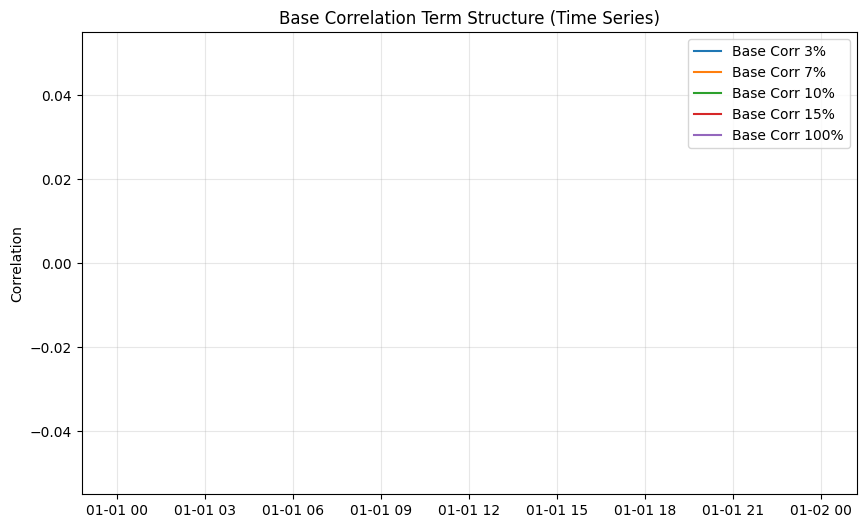

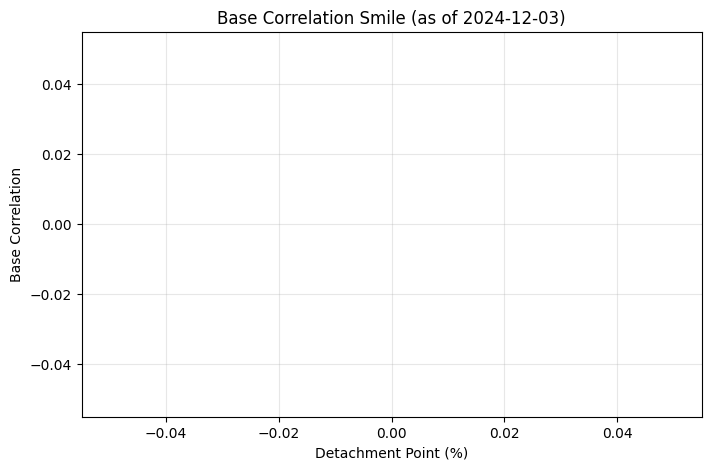

In [20]:


# ==========================================
# 1. MODEL CLASSES (MATH ENGINE)
# ==========================================

class DiscountCurve:
    """Handles OIS discounting."""
    def __init__(self, tenors, rates):
        # Rates inputs are expected in decimals (e.g. 0.03 for 3%)
        self.times = np.array(tenors)
        self.rates = np.array(rates)
        # Linear interpolation of Zero Rates
        self.rate_interp = interp1d(self.times, self.rates, kind='linear', fill_value='extrapolate')

    def get_df(self, t):
        if t <= 1e-6: return 1.0
        r = self.rate_interp(t)
        return np.exp(-r * t)

class SurvivalCurve:
    """Bootstraps survival probabilities from Average CDS Spreads."""
    def __init__(self, discount_curve, tenors, spreads, recovery=0.4):
        self.dc = discount_curve
        self.R = recovery
        self.times = np.array(tenors)
        self.spreads = np.array(spreads) # in decimals
        self.survival_probs = self._bootstrap()
        self.surv_interp = interp1d(np.insert(self.times, 0, 0), np.insert(self.survival_probs, 0, 1.0),
                                    kind='linear', fill_value='extrapolate')

    def _bootstrap(self):
        # Simplified piecewise constant hazard rate bootstrapping
        surv_probs = []
        prev_t = 0
        prev_surv = 1.0

        for i, t in enumerate(self.times):
            s = self.spreads[i]
            # Risky Annuity approximation: sum(DF * S * dt) = (1-R) * (1 - Surv)
            # Detailed bootstrap:
            # Protection ~ (1-R) * (prev_surv - S_t) * DF_mid
            # Premium ~ S * 0.5 * (prev_surv + S_t) * dt * DF_mid
            # Analytic shortcut for Hazard Rate (lambda) ~ S / (1-R)
            # We use the shortcut for stability in LHP contexts, or simple bootstrap:

            lam = s / (1.0 - self.R)
            surv = np.exp(-lam * t)
            surv_probs.append(surv)

        return np.array(surv_probs)

    def get_prob(self, t):
        return self.surv_interp(t)

class GaussianCopulaLHP:
    """
    Large Homogeneous Portfolio (LHP) Model.
    """
    def __init__(self, n_quad=30):
        # Gauss-Hermite Quadrature nodes and weights
        self.x_nodes, self.weights = hermgauss(n_quad)
        # Normalize weights for standard normal PDF
        self.weights /= np.sqrt(np.pi)

    def get_conditional_pd(self, p_t, rho, M):
        """p(t|M) formula"""
        if rho <= 1e-5: return p_t
        if rho >= 0.999: return 1.0 if M < norm.ppf(p_t) else 0.0

        num = norm.ppf(p_t) - np.sqrt(rho) * np.sqrt(2) * M # sqrt(2) for hermgauss scaling
        den = np.sqrt(1 - rho)
        return norm.cdf(num / den)

    def expected_tranche_loss(self, detachment, rho, p_t):
        """
        Calculate E[min(L, K)] for a base tranche [0, K]
        """
        loss_sum = 0.0
        for i, M in enumerate(self.x_nodes):
            # Conditional Portfolio Loss %
            cond_pd = self.get_conditional_pd(p_t, rho, M)
            # LHP assumes Recovery is constant, so Portfolio Loss = cond_pd * (1-R)
            # But usually we work with loss fractions.
            # Tranche loss cap is 'detachment'

            # Note: The standard formula is on Loss Fraction.
            # If PD is 10%, Loss is 6% (assuming R=0.4).
            # The tranche detachment K is also in Loss terms?
            # No, K is usually Notional detachment.
            # We must be careful: Is K input as Notional % or Loss %?
            # Standard convention: K is Notional detachment (e.g. 0.03).
            # Portfolio Loss = PD * (1-R).

            port_loss = cond_pd # This is % of defaults
            # To compare with K (Notional), we need (1-R) factor?
            # Actually, let's keep it clean:
            # L_port = cond_pd * (1 - 0.4)
            # Tranche Loss = Min(L_port, K)

            # However, simpler implementation often treats everything in Notional terms
            # and applies (1-R) at the end. Let's stick to the PPT logic:
            # We need the Expected Loss Amount.

            l_port_val = cond_pd * (1 - 0.4) # Hardcoded R=0.4 per LHP
            tranche_loss_val = min(l_port_val, detachment)

            loss_sum += self.weights[i] * tranche_loss_val

        return loss_sum

class CDXPricer:
    """Prices CDX Tranches."""
    def __init__(self, discount_curve, survival_curve):
        self.df = discount_curve
        self.sc = survival_curve
        self.model = GaussianCopulaLHP(n_quad=64)
        self.R = 0.4

    def pv_legs(self, detachment, rho, tenor):
        """
        Calculates PV Protection and PV Risky Annuity for Base Tranche [0, D]
        """
        dt = 0.25
        times = np.arange(dt, tenor + dt, dt)

        pv_prot = 0.0
        pv_ann = 0.0
        prev_el = 0.0

        for t in times:
            df_t = self.df.get_df(t)
            surv_t = self.sc.get_prob(t)
            p_t = 1.0 - surv_t

            # Expected Loss of Base Tranche [0, D]
            # Note: We pass rho. If rho is NaN/None, we can't calc.
            curr_el = self.model.expected_tranche_loss(detachment, rho, p_t)

            # Protection Leg: Integral DF * dEL
            dEL = curr_el - prev_el
            pv_prot += dEL * df_t

            # Premium Leg: Integral DF * (Remaining_Notional) * dt
            # Remaining Notional = Detachment - Existing_Loss
            curr_rem_notional = detachment - curr_el
            pv_ann += curr_rem_notional * dt * df_t

            prev_el = curr_el

        return pv_prot, pv_ann

    def price_tranche(self, attach, detach, rho_a, rho_d, tenor, quote_type='spread'):
        """
        Returns model value for tranche [A, D].
        If quote_type='upfront', returns Upfront %.
        If quote_type='spread', returns Spread bps.
        """
        # Base [0, D]
        prot_d, ann_d = self.pv_legs(detach, rho_d, tenor)

        # Base [0, A]
        if attach == 0:
            prot_a, ann_a = 0.0, 0.0
        else:
            prot_a, ann_a = self.pv_legs(attach, rho_a, tenor)

        leg_prot = prot_d - prot_a
        leg_ann = ann_d - ann_a

        if leg_ann < 1e-9: return 0.0

        if quote_type == 'upfront':
            # Upfront = PV_Prot - Running_Coupon * PV_Ann
            # Equity runs at 500bps usually
            running_coupon = 0.05
            val = leg_prot - running_coupon * leg_ann
            return val * 100 # Convert to %
        else:
            # Spread = PV_Prot / PV_Ann
            return (leg_prot / leg_ann) * 10000 # Convert to bps

# ==========================================
# 2. DATA PREPARATION FUNCTIONS
# ==========================================

def prepare_data():
    # Load files
    df_cdx = pd.read_csv('cdx_timeseries.csv', parse_dates=['Date'])
    df_ois = pd.read_csv('ois_timeseries.csv', parse_dates=['Date'])
    df_const = pd.read_csv('constituents_timeseries.csv', parse_dates=['Date'])

    # Filter for 5Y Tenor mostly (Standard for CDX)
    df_cdx = df_cdx[df_cdx['Tenor'] == '5Y'].copy()

    # Process OIS: Pivot to have dates as index, tenors as columns
    def parse_ois_tenor(t):
        if 'Y' in t: return float(t.replace('Y', ''))
        if 'M' in t: return float(t.replace('M', '')) / 12.0
        if 'W' in t: return float(t.replace('W', '')) / 52.0
        return 0.0

    df_ois['YearFrac'] = df_ois['Tenor'].apply(parse_ois_tenor)
    ois_pivot = df_ois.pivot(index='Date', columns='YearFrac', values='OIS_Rate')

    # Process Constituents: Calculate Average Spread per day for LHP
    # We need an "Average 5Y Spread" to represent the portfolio
    avg_spreads = df_const.groupby('Date')['Spread_5Y'].mean() / 10000.0 # Convert bps to decimal

    return df_cdx, ois_pivot, avg_spreads

# ==========================================
# 3. MAIN CALIBRATION LOOP
# ==========================================

def run_calibration():
    df_cdx, ois_data, avg_spreads = prepare_data()

    # Storage for results
    results = []

    # Tranche Definitions: (Attach, Detach, QuoteCol, Type)
    tranche_defs = [
        (0.00, 0.03, 'Equity_0_3_Upfront', 'upfront'),
        (0.03, 0.07, 'Mezz_3_7_Spread', 'spread'),
        (0.07, 0.10, 'Mezz_7_10_Spread', 'spread'),
        (0.10, 0.15, 'Senior_10_15_Spread', 'spread'),
        (0.15, 1.00, 'SuperSenior_15_100_Spread', 'spread') # Using 15-100 as approximation for 15-30
    ]

    print("Starting Base Correlation Calibration...")

    # Loop through each date in CDX data
    for date in df_cdx['Date']:
        if date not in ois_data.index or date not in avg_spreads.index:
            continue

        # 1. Build Curves
        # Discount Curve
        day_rates = ois_data.loc[date].dropna()
        dc = DiscountCurve(day_rates.index.values, day_rates.values / 100.0) # rates to decimal

        # Survival Curve (Representative LHP Curve)
        # Using the average spread calculated from constituents
        avg_s = avg_spreads.loc[date]
        # Create a flat term structure for simplicity or use the 5Y point
        sc = SurvivalCurve(dc, [5.0], [avg_s])

        # Pricer Instance
        pricer = CDXPricer(dc, sc)

        # 2. Get Market Data for this date
        market_row = df_cdx[df_cdx['Date'] == date].iloc[0]

        # 3. Calibrate Base Correlations (Bootstrapping)
        # We store Base Correlations: {Detachment: Rho}
        base_corrs = {0.0: 0.0} # Attachment 0 has no correlation

        row_res = {'Date': date, 'Avg_Spread_bps': avg_s * 10000}

        for attach, detach, col, q_type in tranche_defs:
            if col not in market_row: continue

            quote = market_row[col]
            if pd.isna(quote): continue

            # Retrieve known rho for attachment point
            rho_a = base_corrs.get(attach)

            # Objective Function
            def objective(rho_d):
                if rho_d < 0.01 or rho_d > 0.99: return 1e5
                model_val = pricer.price_tranche(attach, detach, rho_a, rho_d, 5.0, q_type)
                return model_val - quote

            try:
                # Solve for rho_d
                implied_rho = brentq(objective, 0.01, 0.99)
                base_corrs[detach] = implied_rho

                # Save Result
                row_res[f'Rho_{int(detach*100)}'] = implied_rho
                row_res[f'Quote_{int(detach*100)}'] = quote

            except Exception as e:
                # print(f"  Failed for {detach} on {date.date()}: {e}")
                row_res[f'Rho_{int(detach*100)}'] = np.nan

        results.append(row_res)

    return pd.DataFrame(results)

# ==========================================
# 4. VISUALIZATION
# ==========================================

def plot_results(df_res):
    if df_res.empty:
        print("No results to plot.")
        return

    # Set Date Index
    df_res.set_index('Date', inplace=True)

    # 1. Base Correlation Time Series
    plt.figure(figsize=(10, 6))
    cols = [c for c in df_res.columns if 'Rho_' in c]
    for c in cols:
        plt.plot(df_res.index, df_res[c], label=f"Base Corr {c.replace('Rho_', '')}%")

    plt.title('Base Correlation Term Structure (Time Series)')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 2. Correlation Smile (Last Available Date)
    last_date = df_res.index[-1]
    last_row = df_res.loc[last_date]

    detachments = []
    rhos = []

    for c in cols:
        detachment = float(c.replace('Rho_', ''))
        rho = last_row[c]
        if not np.nan:
            detachments.append(detachment)
            rhos.append(rho)

    plt.figure(figsize=(8, 5))
    plt.plot(detachments, rhos, 'o-', linewidth=2, markersize=8, color='darkred')
    plt.title(f'Base Correlation Smile (as of {last_date.date()})')
    plt.xlabel('Detachment Point (%)')
    plt.ylabel('Base Correlation')
    plt.grid(True, alpha=0.3)

    # Annotate points
    for x, y in zip(detachments, rhos):
        plt.text(x, y+0.01, f"{y:.2f}", ha='center')

    plt.show()

# ==========================================
# EXECUTION
# ==========================================

if __name__ == "__main__":
    df_results = run_calibration()
    print("Calibration Complete.")
    print(df_results.head())

    plot_results(df_results)